In [ ]:
#https://www.dummies.com/programming/python/plotting-a-sound-file-in-ipython/
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
from gurobipy import *
from IPython.display import Audio
import os
import glob
import untangle

# Functions

In [2]:
# Function for transforming a signal with fourier
def fourier_trans(data, rate, begin_time, end_time): 
    # initialising variables
    tp_count = len(data)
    values = np.arange(int(tp_count/2))
    time_period = tp_count/rate
    frequencies = values/time_period
    
    #at what intervals time points are sampled
    sampling_interval = 1/rate;
    
    #time points
    time = np.arange(begin_time, end_time, sampling_interval);
    
    #Frequency domain representation
    fourier_transform = fft(data)/tp_count #normalized the amplitude
    fourier_transform = fourier_transform[range(int(len(data)/2))] #exclude sampling frequency
    
    return frequencies, abs(fourier_transform)

# Frequency domain representation
def plot_freq_domain(freq, fourier,name):
    plt.figure(figsize=(20,5))
    plt.plot(freq, fourier)
    plt.xlabel('Frequency in Hz')
    plt.ylabel('Amplitude')
    plt.xlim(0, 1300)
    plt.title(name)
    plt.show()

# Dictonary

In [3]:
# Read WAV File

audio_files = []
path_wav = "audiofile"
path_xml = "annotation"

# Init dict
ref_note = {}

note = 0

for filename in glob.glob(os.path.join(path_xml, '*.xml')):
    
    # Read data from xml
    obj = untangle.parse(filename)
    audiofile = obj.instrumentRecording.globalParameter.audioFileName.cdata
    pitch = obj.instrumentRecording.transcription.event.pitch.cdata
    onsetSec = obj.instrumentRecording.transcription.event.onsetSec.cdata
    offsetSec = obj.instrumentRecording.transcription.event.offsetSec.cdata
    fretNumber = obj.instrumentRecording.transcription.event.fretNumber.cdata
    stringNumber = obj.instrumentRecording.transcription.event.stringNumber.cdata
    
    # Read wav
    wav_file = path_wav + '/' + audiofile
    rate, data = wav.read(wav_file)
    
    # Calc FFT
    #freq, fourier = fourier_trans(data, rate, float(onsetSec), float(offsetSec))
    freq, fourier = fourier_trans(data, rate, 1, 1.2)
    
    # Update Dict
    #ref_note[filename] = {
    ref_note[note] = {
        "pitch": int(pitch),
        "fret": int(fretNumber),
        "string": int(stringNumber),
        "rate": rate,
        "data": data,
        "onset": float(onsetSec), 
        "offset": float(offsetSec), 
        "freq": freq,
        "fourier": fourier,
    }
    note+=1

# Chord Approximation


In [4]:
# Mischsignal
#rate_chord, data_chord = wav.read('audiofile/1-E1-Major 00.wav')
#rate_chord, data_chord = wav.read('audiofile/1-E1-Major 01.wav')

# Single note
rate_chord, data_chord = wav.read('audiofile/G53-65601-1111-00067.wav')

# Single note played on another guitar
#rate_chord, data_chord = wav.read('audiofile/G53-42102-1111-237.wav')

#freq, mischsignal = fourier_trans(data_chord, rate_chord, 0, 2.5)
freq, mischsignal = fourier_trans(data_chord, rate_chord, 1, 1.2)

In [5]:
print('Länge Mischsignal: ', len(mischsignal))
print('Länge Data: ', len(data_chord))

Länge Mischsignal:  55125
Länge Data:  110250


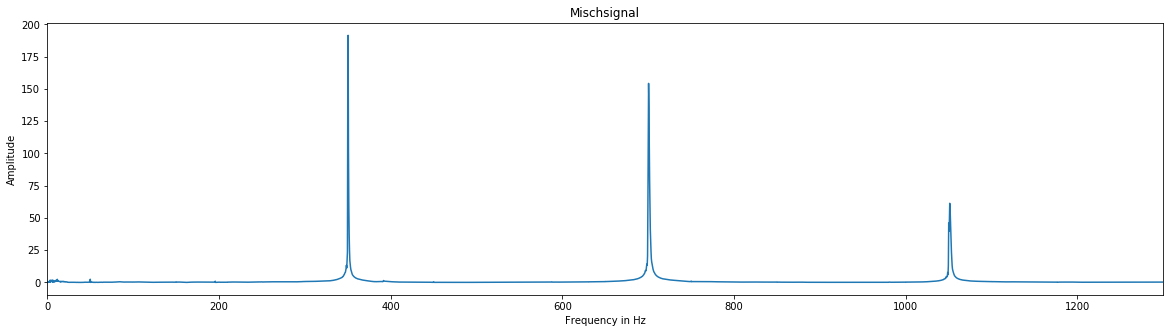

In [6]:
# plot mischsignal
plot_freq_domain(freq, mischsignal, 'Mischsignal')

In [7]:
'''
ampl_const = 200
fourier_list = list(mischsignal)
ampl_peaks = list(filter(lambda i: i > 150, fourier_list))

for x in range(len(ampl_peaks)):
    index = fourier_list.index(ampl_peaks[x])
    print('Frequenz bei Index {0}: {1}Hz mit einer Amplitude von: {2:0.2f}dB'
          .format(index, freq[index], ampl_peaks[x]))
'''

"\nampl_const = 200\nfourier_list = list(mischsignal)\nampl_peaks = list(filter(lambda i: i > 150, fourier_list))\n\nfor x in range(len(ampl_peaks)):\n    index = fourier_list.index(ampl_peaks[x])\n    print('Frequenz bei Index {0}: {1}Hz mit einer Amplitude von: {2:0.2f}dB'\n          .format(index, freq[index], ampl_peaks[x]))\n"

# Gurobi

In [8]:
# Build Model
m = Model()

lambs = []
for lamb in range(len(ref_note)):
    lambs.append(m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_' + str(lamb)))
m.update()

Academic license - for non-commercial use only


In [9]:
%%time
#Optimize Signal

deviation = 0
approxi_sgn = 0
 
#for sgn in range(len(mischsignal)):
for sgn in range(50):
    for lamb in range(len(lambs)):
    #for lamb in range(10):
        approxi_sgn += lambs[lamb] * ref_note[lamb]['fourier'][sgn]
        
    deviation += ((mischsignal[sgn] - approxi_sgn)*(mischsignal[sgn] - approxi_sgn))
    #print('sgn: ', approxi_sgn)
print('Deviation is calculated.')

Deviation is calculated.
Wall time: 4min 12s


In [10]:
%%time
m.setObjective(deviation, GRB.MINIMIZE)
m.optimize()
 
for v in m.getVars():
    print('%s: %g' % (v.varName, v.x))

Optimize a model with 0 rows, 78 columns and 0 nonzeros
Model has 3081 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e+02, 6e+03]
  QObjective range [2e+03, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.14s
Presolved: 0 rows, 78 columns, 0 nonzeros
Presolved model has 3081 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 50
 AA' NZ     : 1.225e+03
 Factor NZ  : 1.275e+03
 Factor Ops : 4.293e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.24068154e+08  5.35299977e+01  5.23e+04 4.31e+00  1.00e+06     0s
   1  -1.20279307e+07 -1.06449775e+05  5.12e+03 4.22e-01  1.03e+05     0s
   2  -5.45883378e+05 -7.09197149e+03  2.33e+02 1.92e-02  4.94e+03     0s
   3  -2.01625407e+04 -8.82695216e+02  8.83e+00 7.28e-04  2.09e+